In [27]:
#Import necessary modules and libraries

import pandas as pd
from datetime import datetime
import dateutil.parser
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import numpy as np
import re
import pycld2 as cld2
import reverse_geocode
import reverse_geocoder
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

#from pygeocoder import Geocoder

#Initialize plotly for offline plotting
#plotly.offline.init_notebook_mode(connected=True)

#import geopandas
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [2]:
hotel_df = pd.read_csv('hotel_reviews.csv')
hotel_df.drop_duplicates()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN
5,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel,NaN,A Traveler,NaN
6,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-06-10T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.,NaN,A Traveler,NaN
7,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-05-14T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,ottimo soggiorno e ottima sistemazione nei gio...,Lovely view out onto the lagoon. Excellent view.,NaN,A Traveler,NaN
8,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-09-14T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,3.0,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,G��nstige Lage,NaN,Doppeldecker,NaN
9,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-05-16T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Lidoen er perfekt til et par dages ro og afsla...,Ro og hygge,NaN,A Traveler,NaN


In [3]:
hotel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
address                 35912 non-null object
categories              35912 non-null object
city                    35912 non-null object
country                 35912 non-null object
latitude                35826 non-null float64
longitude               35826 non-null float64
name                    35912 non-null object
postalCode              35857 non-null object
province                35912 non-null object
reviews.date            35653 non-null object
reviews.dateAdded       35912 non-null object
reviews.doRecommend     0 non-null float64
reviews.id              0 non-null float64
reviews.rating          35050 non-null float64
reviews.text            35890 non-null object
reviews.title           34290 non-null object
reviews.userCity        16263 non-null object
reviews.username        35869 non-null object
reviews.userProvince    17518 non-null object
dtypes: float64(5), 

### Data Wrangling

In [4]:
#Drop null columns
hotel_df.drop(['reviews.doRecommend','reviews.id'], axis=1, inplace=True, errors='ignore')

In [5]:
#Drop rows with no text reviews
hotel_df = hotel_df.dropna(subset=['reviews.text'], axis=0)

In [6]:
#Drop reviews that consist only of URL links
hotel_df = hotel_df[hotel_df['reviews.text'].apply(lambda x: len(re.sub('^http.*\.com|^www\..*\.com','',x)) > 0)]

In [7]:
#Find length of text reviews
hotel_df['len_textReview'] = hotel_df['reviews.text'].apply(len)

In [8]:
hotel_df.len_textReview.describe()

count    35890.000000
mean       253.449289
std        218.903929
min          1.000000
25%        100.000000
50%        221.000000
75%        330.000000
max       3772.000000
Name: len_textReview, dtype: float64

In [9]:
#Function to calculate percentage of capital letters in reviews
def percentCaps(s):
    numCaps = 0
    for i in s:
        if (i.isupper()):
            numCaps += 1
    return float(numCaps)/float(len(s))

In [10]:
hotel_df['reviewPercentCaps'] = hotel_df['reviews.text'].apply(percentCaps)

In [11]:
#Functions to detect language of text and percent confidence in accuracy of detected language
def detect_lang(s):
    isReliable, textBytes, details = cld2.detect(s)
    return details[0][0]

def detect_conf(s):
    isReliable, textBytes, details = cld2.detect(s)
    return details[0][2]

In [12]:
#Apply language detection and confidence in detection to reviews
hotel_df['lang'] = hotel_df['reviews.text'].apply(detect_lang)

In [13]:
hotel_df['lang_conf'] = hotel_df['reviews.text'].apply(detect_conf)

In [14]:
#Keep only reviews that are predicted to be written in English with a high level of confidence
english_reviews = hotel_df[(hotel_df['lang'] == 'ENGLISH') & (hotel_df['lang_conf'] >= 95)]

In [15]:
#Verify that 'reviews.dateAdded' shouldn't be used as the date column
#Look for clustering in number of ratings by date in this column -- if there are a few dates with very large counts relative to others, it suggests that many reviews were added to a database at the same time. In that case, use 'reviews.date' instead as date column corresponding to when the user wrote a review
english_reviews['reviews.dateAdded'].value_counts(dropna=False).head(30)

2017-04-20T01:34:00Z    1126
2017-04-17T01:54:07Z     636
2016-11-06T21:15:05Z     431
2017-03-02T17:51:10Z     358
2016-11-15T11:22:55Z     312
2016-11-21T23:26:38Z     299
2016-10-27T13:17:27Z     292
2017-03-26T17:25:47Z     280
2016-11-21T15:26:42Z     275
2016-11-16T02:50:03Z     273
2016-10-19T04:52:22Z     266
2016-10-27T21:54:40Z     258
2016-10-27T18:09:11Z     232
2017-02-24T10:25:45Z     225
2016-10-30T21:12:22Z     219
2016-11-16T04:20:44Z     201
2016-11-17T15:13:00Z     193
2016-11-03T22:46:53Z     192
2016-10-29T20:21:45Z     183
2016-10-31T20:24:02Z     178
2016-10-27T18:54:12Z     177
2016-11-05T20:26:14Z     171
2016-10-28T20:29:21Z     169
2016-06-23T16:50:58Z     166
2016-10-29T19:04:25Z     164
2016-11-14T21:34:50Z     162
2016-06-22T19:05:58Z     158
2016-11-16T07:30:07Z     156
2016-11-02T02:09:01Z     155
2016-08-03T21:09:14Z     152
Name: reviews.dateAdded, dtype: int64

In [16]:
#Use 'reviews.date' as date column
#Drop rows with null values in date column and ratings column
english_reviews = english_reviews.dropna(subset=['reviews.date','reviews.rating'], axis=0)

In [17]:
#Look at counts of ratings
english_reviews['reviews.rating'].value_counts()

5.0     11832
4.0      8972
3.0      5316
1.0      2876
2.0      2841
10.0       98
0.0        88
9.6        51
9.2        49
4.8        25
7.5        24
4.3        24
8.3        24
8.8        23
7.9        23
4.2        21
3.4        17
4.1        13
6.3        13
4.5        13
7.1        12
6.7        10
5.4         9
3.1         7
4.6         7
3.3         6
5.8         6
4.7         6
4.9         6
4.4         6
3.8         3
2.4         3
3.7         2
2.5         2
3.9         2
3.2         2
9.5         1
1.3         1
6.0         1
1.5         1
7.0         1
2.8         1
2.9         1
Name: reviews.rating, dtype: int64

In [18]:
#Examine reviews with a rating of 0.0
english_reviews[english_reviews['reviews.rating'] == 0.0]['reviews.text']

79       to share your opinion of this businesswith YP ...
1455            Two tubs and a heated pool!!  Soak it in!!
1458     to share your opinion of this businesswith YP ...
1493     Free coffee refills and budget rates make this...
1587     to share your opinion of this businesswith YP ...
2020     to share your opinion of this businesswith YP ...
3619     to share your opinion of this businesswith YP ...
3926     to share your opinion of this businesswith YP ...
4013                    Great place to stay! Great price !
4303     to share your opinion of this businesswith YP ...
4366     to share your opinion of this businesswith YP ...
6091     to share your opinion of this businesswith YP ...
6668     to share your opinion of this businesswith YP ...
7293     to share your opinion of this businesswith YP ...
7791     to share your opinion of this businesswith YP ...
9006     to share your opinion of this businesswith YP ...
9125     to share your opinion of this businesswith YP .

In [19]:
#Since a rating of 0.0 doesn't correspond consistently to a good or bad review, drop ratings of 0.0
english_reviews = english_reviews[english_reviews['reviews.rating'] != 0.0]

In [20]:
#Drop nonexistent reviews that have simply been filled in with 'to share your opinion of this business...'
english_reviews = english_reviews[english_reviews['reviews.text'].apply(lambda x: len(re.sub("^to share your opinion of.*",'',x)) > 0)]

In [21]:
#Examine hotels with a rating of more than 5.0
english_reviews[english_reviews['reviews.rating'] > 5.0].groupby('name').first()

,address,categories,city,country,latitude,longitude,postalCode,province,reviews.date,reviews.dateAdded,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince,len_textReview,reviewPercentCaps,lang,lang_conf
name,,,,,,,,,,,,,,,,,,,,
Candlewood Suites Eugene Springfield,3005 Franklin Blvd,"Hotel, Conference Room, and Meeting Room South...",Eugene,US,44.044020,-123.047619,97403,OR,2016-08-15T00:00:00Z,2016-11-06T04:14:25Z,6.3,Tripping over the air conditioner when getting...,Easy access,Dallas,Dorothy,TX,83,0.024096,ENGLISH,98
Hampton Inn Virginia Beach Oceanfront North,3107 Atlantic Ave,"Hotel,Hotels",Virginia Beach,US,36.859787,-75.978035,23451-2934,VA,2016-09-06T00:00:00Z,2016-11-21T23:26:38Z,6.3,First of all the noise( very loud bass ) at ni...,Loud bass,Harrisonburg,Joseph,VA,274,0.021898,ENGLISH,99
Holiday Inn Express Hotel and Suites Va Beach Oceanfront,2607 Atlantic Ave,Hotels,Virginia Beach,US,36.854972,-75.976419,23451,VA,2016-05-12T00:00:00Z,2016-10-30T21:12:22Z,6.3,I use the staircase instead of the elevator mo...,Needs a little TLC,Martinsburg,Gary,WV,548,0.018248,ENGLISH,99
Hyatt Regency Kathmandu,Taragaon Boudha,Hotels,Alliance,US,27.721600,85.355959,44601,OH,2015-08-11T00:00:00Z,2016-11-11T23:48:28Z,9.6,The wifi signal was too low Loved The location,Location,NaN,Mohsin,NaN,46,0.065217,ENGLISH,97
Pelican Shores Inn,2645 N W Inlet Ave,"Hotels,Lodging,Hotel,Motels",Lincoln City,US,44.984655,-124.013787,97367,OR,2015-10-20T00:00:00Z,2016-11-17T14:29:44Z,10.0,I like the vanity area in the bedroom so I can...,Can't wait to come back next year!,Eatonville,Mary,WA,224,0.017857,ENGLISH,99


In [22]:
#Drop rows with null values in latitude and longitude columns
english_reviews = english_reviews.dropna(subset=['latitude','longitude'], axis=0)

In [24]:
#Functions to identify true country and city of hotels based on lat/long coordinates using reverse_geocode module
def get_country(coords):
    loc_dict = reverse_geocode.search(coords)[0]
    return loc_dict['country']

def get_city(coords):
    loc_dict = reverse_geocode.search(coords)[0]
    return loc_dict['city']

In [25]:
english_reviews['coordinates'] = list(zip(english_reviews['latitude'], english_reviews['longitude']))

In [29]:
#Apply functions above to get additional location information for each review
english_reviews['loc_country'] = english_reviews['coordinates'].apply(lambda x: get_country([x]))
english_reviews['loc_city'] = english_reviews['coordinates'].apply(lambda x: get_city([x]))

In [26]:
english_reviews[english_reviews['loc_country'] != 'United States'].groupby('name').first()

,address,categories,city,country,latitude,longitude,postalCode,province,reviews.date,reviews.dateAdded,...,reviews.userCity,reviews.username,reviews.userProvince,len_textReview,reviewPercentCaps,lang,lang_conf,coordinates,loc_country,loc_city
name,,,,,,,,,,,,,,,,,,,,,
Amisos Hotel,Ebusuud Cad No2,Hotels,Naples,US,41.011854,28.978276,34110,FL,2015-01-20T00:00:00Z,2016-11-16T03:58:35Z,...,NaN,���������������������������������,NaN,452,0.033186,ENGLISH,99,"(41.011854, 28.978276)",Turkey,Eminönü
Arion,40 Apollonos St,Hotels,Ramey,US,37.812115,23.774569,16671,PA,2015-07-27T00:00:00Z,2016-10-28T21:35:35Z,...,NaN,Paul,NaN,129,0.023256,ENGLISH,99,"(37.812115000000006, 23.774569)",Greece,Vouliagméni
Azul Beach Hotel By Karisma Gourmet Inclusive,Carretera Cancun,Hotels,Mont Belvieu,US,20.905720,-86.847860,77580,TX,2016-05-15T00:00:00Z,2016-11-15T22:27:45Z,...,NaN,Alejandro,NaN,125,0.024000,ENGLISH,99,"(20.905720000000002, -86.84786)",Mexico,Alfredo V. Bonfil
Best Western Hotel De Neuville,3 Rue Verniquet,Hotels,Irving,US,48.886905,2.300571,75017,TX,2014-08-20T00:00:00Z,2016-11-01T01:10:00Z,...,NaN,A Traveler,NaN,101,0.009901,ENGLISH,99,"(48.886905, 2.3005709999999997)",France,Levallois-Perret
Best Western Saint-etienne Aeroport,2 Boulevard Pierre Desgranges,Hotels,Park City,US,45.531554,4.278685,42160,KY,2014-07-15T00:00:00Z,2016-11-15T21:41:39Z,...,NaN,The Harrisons,NaN,594,0.018519,ENGLISH,99,"(45.531554, 4.278685)",France,Andrézieux-Bouthéon
Campanile Lyon Ecully,42 Avenue Guy De Collongue,Hotels,Cozad,US,45.787482,4.764851,69130,NE,2015-01-14T00:00:00Z,2016-08-03T09:48:29Z,...,NaN,David,NaN,260,0.011538,ENGLISH,99,"(45.787482000000004, 4.764851)",France,Écully
City Express Irapuato,Blvd Villas De Irapuato 1362,Hotels,Mobile,US,20.683032,-101.380828,36670,AL,2015-07-08T00:00:00Z,2016-11-09T18:48:11Z,...,NaN,A Traveler,NaN,51,0.039216,ENGLISH,98,"(20.683032, -101.38082800000001)",Mexico,Villas de Irapuato
Comfort Hotel Bernau,Zepernicker Chaussee 39/53,"Hotel,Bernau Hotels",East Hickory,US,52.673980,13.568842,16321,PA,2014-01-01T00:00:00Z,2016-03-07T13:02:51Z,...,Schweinfurt,hbaker10,NaN,667,0.031484,ENGLISH,99,"(52.67398000000001, 13.568842000000002)",Germany,Bernau bei Berlin
Comfort Hotel Nation Pere Lachaise Paris 11,12 Rue Leon Frot,Hotels,Carrollton,US,48.853660,2.388030,75011,TX,2014-04-23T00:00:00Z,2016-10-27T18:52:23Z,...,NaN,A Traveler,NaN,24,0.083333,ENGLISH,95,"(48.85366, 2.38803)",France,Bagnolet


In [27]:
#After searching for the hotel names on Google Maps, I found that the incorrect locations above are due to incorrectly matching on the postal code. The script or person that filled in the data in the original dataset has assumed the postal code is a US ZIP code, and added corresponding US-based city/state information.
#Keep only those reviews for hotels that are actually located in the US
english_reviews = english_reviews[english_reviews['loc_country'] == 'United States']

In [28]:
#The number of reviews that have fractional ratings or ratings greater than 5.0 is small relative to the size of the dataset, so I will omit them from the rest of the analysis for the sake of convenience during statistical inference & model-building.
np.sum(english_reviews['reviews.rating'].value_counts().loc[10.0:])

455

In [29]:
#Keep only integer-valued ratings from 1 to 5
english_reviews = english_reviews[english_reviews['reviews.rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]

In [30]:
np.sum(english_reviews['reviews.rating'].value_counts())

29711

In [31]:
#Convert dates to string format
english_reviews['reviewsDateString'] = english_reviews['reviews.date'].apply(str)

In [32]:
#Convert dates from strings to datetime objects
english_reviews['reviewsDatetime'] = english_reviews['reviewsDateString'].apply(dateutil.parser.parse)

In [33]:
#Functions to extract weekday and month as words from datetime column
def get_weekday(x):
    days = ['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']
    return days[x]

def get_month(x):
    months = ['January','February','March','April','May','June','July','August','September','October','November','December']
    return months[x-1]

english_reviews['weekday_num'] = english_reviews['reviewsDatetime'].apply(datetime.weekday)
english_reviews['weekday'] = english_reviews['weekday_num'].apply(get_weekday)

english_reviews['month_num'] = english_reviews['reviewsDatetime'].apply(lambda x: x.month)
english_reviews['month'] = english_reviews['month_num'].apply(get_month)

### Data Storytelling

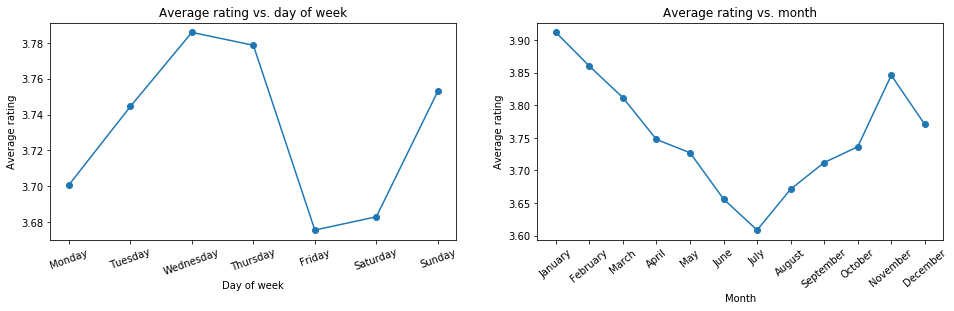

In [34]:
#Plot average star rating by day of week
avg_rating_by_weekday = pd.Series(english_reviews.groupby('weekday_num')['reviews.rating'].mean().values, index=np.array(['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']))
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(avg_rating_by_weekday, marker='o')
plt.title('Average rating vs. day of week')
plt.xlabel('Day of week')
plt.xticks(np.arange(7), labels=list(avg_rating_by_weekday.index), rotation=20)
plt.ylabel('Average rating')

#Plot average rating by month
avg_ratings_by_month = pd.Series(english_reviews.groupby('month_num')['reviews.rating'].mean().values, index=np.array(['January','February','March','April','May','June','July','August','September','October','November','December']))
plt.subplot(1,2,2)
plt.plot(avg_ratings_by_month, marker='o')
plt.title('Average rating vs. month')
plt.xlabel('Month')
plt.xticks(rotation=40)
plt.ylabel('Average rating')
plt.show()

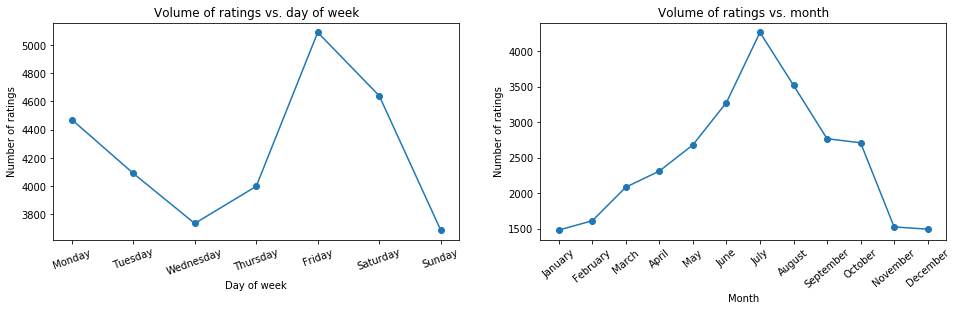

In [35]:
#Plot volume of ratings by day of week
num_ratings_by_weekday = pd.Series(english_reviews.groupby('weekday_num')['reviews.rating'].count().values, index=np.array(['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday']))
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(num_ratings_by_weekday, marker='o')
plt.title('Volume of ratings vs. day of week')
plt.xlabel('Day of week')
plt.xticks(rotation=20)
plt.ylabel('Number of ratings')

#Plot volume of ratings per month
num_ratings_by_month = pd.Series(english_reviews.groupby('month_num')['reviews.rating'].count().values, index=np.array(['January','February','March','April','May','June','July','August','September','October','November','December']))
plt.subplot(1,2,2)
plt.plot(num_ratings_by_month, marker='o')
plt.title('Volume of ratings vs. month')
plt.xlabel('Month')
plt.xticks(rotation=40)
plt.ylabel('Number of ratings')
plt.show()

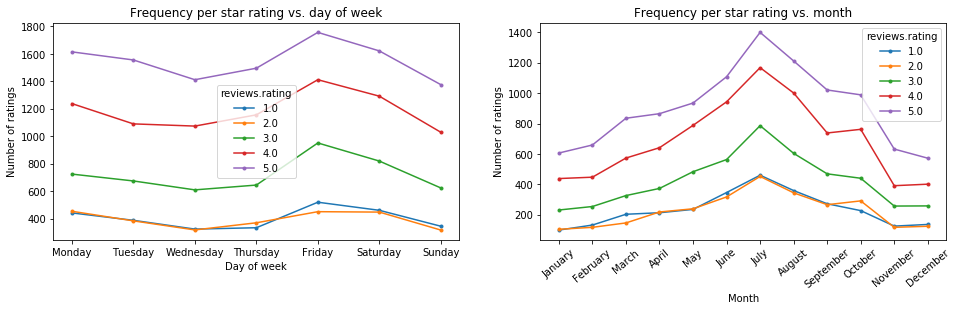

In [36]:
#Make crosstabulations of frequencies of ratings and weekdays, ratings and months
#Make line plots of each star rating across weekdays & across months
ratings_weekday_crosstab = pd.crosstab(english_reviews['reviews.rating'], english_reviews['weekday_num'])
ratings_month_crosstab = pd.crosstab(english_reviews['reviews.rating'], english_reviews['month_num'])
fig, axes = plt.subplots(1,2, figsize=(16,4))
plot_weekdays = ratings_weekday_crosstab.transpose().plot(title='Frequency per star rating vs. day of week', marker='.', ax=axes[0])
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(list(num_ratings_by_weekday.index), minor=False)
axes[0].set(xlabel='Day of week', ylabel='Number of ratings')

plot_months = ratings_month_crosstab.transpose().plot(title='Frequency per star rating vs. month', marker='.', rot=40, ax=axes[1])
axes[1].set_xticks(np.arange(1,13))
axes[1].set_xticklabels(list(num_ratings_by_month.index), minor=False)
axes[1].set(xlabel='Month', ylabel='Number of ratings')
plt.show()

In [37]:
#Make Pandas Series of dates for line plots by hour of day and day of month
series_dates = pd.Series(english_reviews['reviews.rating'].values, index=english_reviews['reviewsDatetime'])

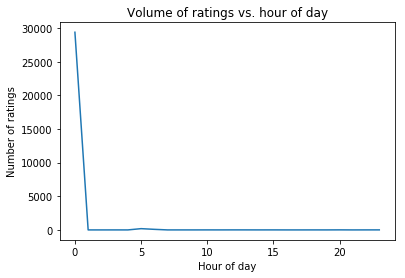

In [38]:
#Plot number of ratings by hour of day
num_ratings_by_hour = series_dates.groupby(series_dates.index.hour).count()
plt.plot(num_ratings_by_hour)
plt.title('Volume of ratings vs. hour of day')
plt.xlabel('Hour of day')
plt.ylabel('Number of ratings')
plt.show()

In [39]:
#Most ratings do not seem to have an hour other than 0 in their timestamp. The number of ratings with a non-zero hour field is small relative to the size of the data, so the hour of day is not significant to the analysis of ratings over time:
num_ratings_not_time_zero = num_ratings_by_hour.iloc[1:]
num_ratings_not_time_zero.sum()

338

In [40]:
#Hotels with a non-zero hour are spread across various states and categories, so the hour info may be specific to the website where the reviews were posted
english_reviews[english_reviews['reviewsDatetime'].apply(lambda x: x.hour > 0)].groupby('name').first()

,address,categories,city,country,latitude,longitude,postalCode,province,reviews.date,reviews.dateAdded,...,lang_conf,coordinates,loc_country,loc_city,reviewsDateString,reviewsDatetime,weekday_num,weekday,month_num,month
name,,,,,,,,,,,,,,,,,,,,,
Best Western Plus Waterville Grand Hotel,375 Main St,"Hotels,Hotel",Waterville,US,44.570590,-69.640120,4901,ME,2014-10-18T05:00:00Z,2016-10-27T13:17:27Z,...,98,"(44.57059, -69.64012)",United States,Carmel,2014-10-18T05:00:00Z,2014-10-18 05:00:00+00:00,5,Saturday,10,October
Best Western Plus-seaport Inn,33 Peck,"Hotels,Accommodations & Lodging,Motels",New York,US,40.708060,-74.001450,10038,Nyc,2011-07-05T22:48:13Z,2017-03-24T20:49:21Z,...,99,"(40.708059999999996, -74.00145)",United States,Financial District,2011-07-05T22:48:13Z,2011-07-05 22:48:13+00:00,1,Tuesday,7,July
Candlewood Suites Indianapolis Northwest,7455 Woodland Dr,"Travel and Tourism,Extended Stay,Hotels,Hotel,...",Indianapolis,US,39.888268,-86.265090,46278,IN,2011-12-09T06:00:00Z,2015-11-06T12:02:29Z,...,96,"(39.888268, -86.26509)",United States,Zionsville,2011-12-09T06:00:00Z,2011-12-09 06:00:00+00:00,4,Friday,12,December
Candlewood Suites Oklahoma City-moore,1701 N Moore Ave,"Wedding Receptions & Parties,Convention & Meet...",Moore,US,35.351797,-97.495296,73160-3669,OK,2015-07-01T12:34:59Z,2017-04-02T18:04:32Z,...,99,"(35.351797, -97.495296)",United States,Moore,2015-07-01T12:34:59Z,2015-07-01 12:34:59+00:00,2,Wednesday,7,July
"Club Quarters, Rockefeller Center",25 W 51st St,Hotels,New York,US,40.760020,-73.978387,10019,Nyc,2009-05-31T13:37:55Z,2017-03-30T14:11:33Z,...,99,"(40.760020000000004, -73.978387)",United States,Gramercy Park,2009-05-31T13:37:55Z,2009-05-31 13:37:55+00:00,6,Sunday,5,May
"Country Inn & Suites By Carlson, Rocky Mount, Nc",672 English Rd,"Family-Friendly Hotels,Hotels & Motels,Budget ...",Rocky Mount,US,35.979098,-77.847276,27804,NC,2012-02-04T06:00:00Z,2016-12-13T04:53:50Z,...,99,"(35.979098, -77.84727600000001)",United States,Rocky Mount,2012-02-04T06:00:00Z,2012-02-04 06:00:00+00:00,5,Saturday,2,February
Days Inn Lincolnton,614 Clark Dr,"Hotels,Hotel",Lincolnton,US,35.471120,-81.239980,28092,NC,2015-01-12T06:00:00Z,2016-01-24T23:04:55Z,...,98,"(35.47112, -81.23998)",United States,Lincolnton,2015-01-12T06:00:00Z,2015-01-12 06:00:00+00:00,0,Monday,1,January
Eaglecrest Ski Area,155 S Seward St,"ski & snowboard areas,Resorts,Lodging,Travel,S...",Juneau,US,58.299629,-134.405992,99801,AK,2013-04-24T05:00:00Z,2015-05-22T10:13:02Z,...,99,"(58.299629, -134.405992)",United States,Juneau,2013-04-24T05:00:00Z,2013-04-24 05:00:00+00:00,2,Wednesday,4,April
Eden Park Guest House,7063 Carroll Ave,"Travel and Tourism,Hotels,Hotel,Lodging,Resort...",Takoma Park,US,38.975280,-77.009910,20912,MD,2012-07-10T05:00:00Z,2015-11-06T08:02:53Z,...,99,"(38.97528, -77.00990999999999)",United States,Takoma Park,2012-07-10T05:00:00Z,2012-07-10 05:00:00+00:00,1,Tuesday,7,July


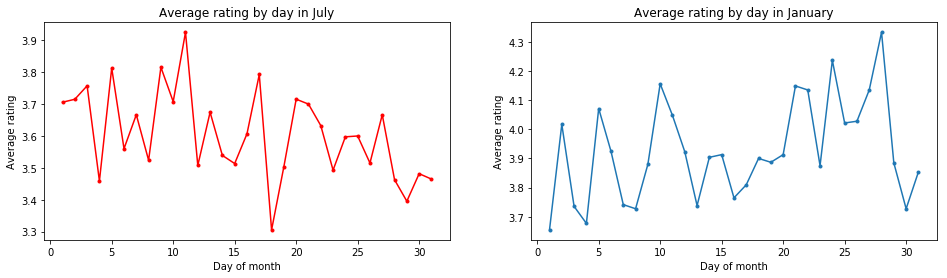

In [41]:
#Plot average rating by day in July
july_reviews = series_dates[series_dates.index.month == 7]
july_reviews_by_day = july_reviews.groupby(july_reviews.index.day).mean()
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(july_reviews_by_day, color='r', marker='.')
plt.title('Average rating by day in July')
plt.xlabel('Day of month')
plt.ylabel('Average rating')

#Plot average rating by day in January
jan_reviews = series_dates[series_dates.index.month == 1]
jan_reviews_by_day = jan_reviews.groupby(jan_reviews.index.day).mean()
plt.subplot(1,2,2)
plt.plot(jan_reviews_by_day, marker='.')
plt.title('Average rating by day in January')
plt.xlabel('Day of month')
plt.ylabel('Average rating')
plt.show()

In [42]:
#Most reviews are from 2014-2016
series_dates.index.year.value_counts()

2016    13572
2015    10175
2014     2456
2013     1238
2012      780
2011      617
2010      292
2008      193
2009      154
2017       87
2007       56
2006       46
2005       22
2002       13
2004        5
2003        5
Name: reviewsDatetime, dtype: int64

/Users/sneha/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



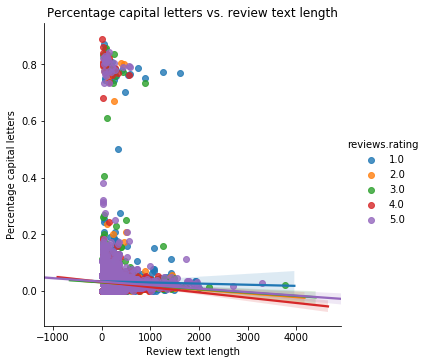

In [43]:
#Plot linear regression of percentage capital letters versus review text length, and also display relationship between these two variables and ratings using color
sns.lmplot(x='len_textReview', y='reviewPercentCaps', hue='reviews.rating', data=english_reviews)
plt.title('Percentage capital letters vs. review text length')
plt.xlabel('Review text length')
plt.ylabel('Percentage capital letters')
plt.show()

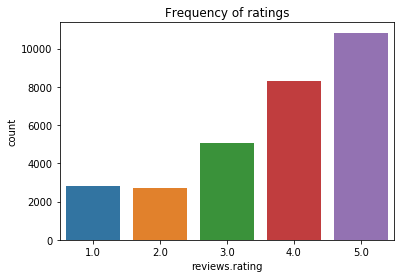

In [44]:
#Plot bar graph of ratings
sns.countplot(x='reviews.rating', data=english_reviews)
plt.title('Frequency of ratings')
plt.show()

In [45]:
#Partition reviews into 2 groups: hotels rated 4 or 5 stars and hotels rated lower than 4 stars
higher_ratings = english_reviews[english_reviews['reviews.rating'] >= 4.0]
lower_ratings = english_reviews[english_reviews['reviews.rating'] < 4.0]

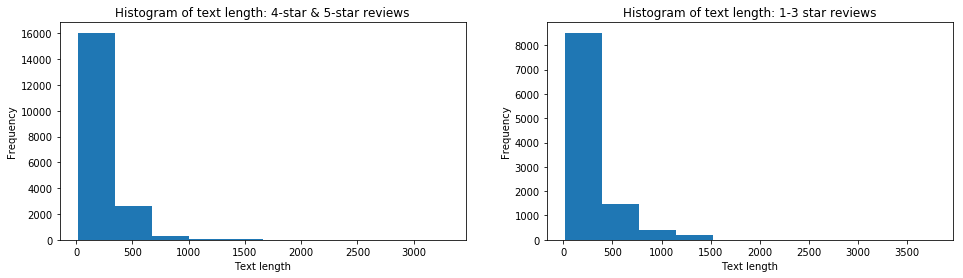

In [46]:
#Plot histogram of review text length for well-rated hotels
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.hist(higher_ratings['len_textReview'].values)
plt.title('Histogram of text length: 4-star & 5-star reviews')
plt.xlabel('Text length')
plt.ylabel('Frequency')

#Plot histogram of review text length for lesser-rated hotels
plt.subplot(1,2,2)
plt.hist(lower_ratings['len_textReview'].values)
plt.title('Histogram of text length: 1-3 star reviews')
plt.xlabel('Text length')
plt.ylabel('Frequency')
plt.show()

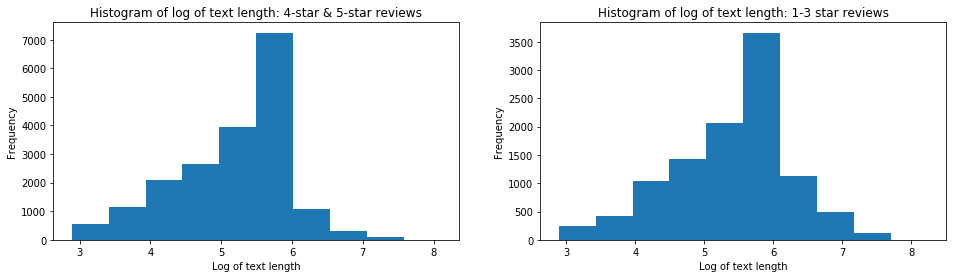

In [47]:
#The distributions above look to be log-normal, so try taking the log of length of review text to transform to normality
#Plot histogram of log of review text length for well-rated hotels
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.hist(np.log(higher_ratings['len_textReview'].values))
plt.title('Histogram of log of text length: 4-star & 5-star reviews')
plt.xlabel('Log of text length')
plt.ylabel('Frequency')

#Plot histogram of log of review text length for lesser-rated hotels
plt.subplot(1,2,2)
plt.hist(np.log(lower_ratings['len_textReview'].values))
plt.title('Histogram of log of text length: 1-3 star reviews')
plt.xlabel('Log of text length')
plt.ylabel('Frequency')
plt.show()

The distributions of log(text length) appear nearly identical for the well-rated and lesser-rated hotels. However, I will perform a t-test for the difference of the mean log(text length) between the two groups, to check if there is a statistically significant difference in the average review text length based on how well the hotel is rated.

In [48]:
#Create DataFrame to plot proportions of high and low ratings by weekday
high_low_by_weekday = pd.concat([lower_ratings.groupby('weekday_num')['reviews.rating'].count(), higher_ratings.groupby('weekday_num')['reviews.rating'].count()], axis=1)
high_low_by_weekday.columns = ['lower_ratings','higher_ratings']
high_low_by_weekday.index = np.array(['Monday','Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'])

In [49]:
#Create DataFrame to plot proportions of high and low ratings by month
high_low_by_month = pd.concat([lower_ratings.groupby('month_num')['reviews.rating'].count(), higher_ratings.groupby('month_num')['reviews.rating'].count()], axis=1)
high_low_by_month.columns = ['lower_ratings','higher_ratings']
high_low_by_month.index = np.array(['January','February','March','April','May','June','July','August','September','October','November','December'])

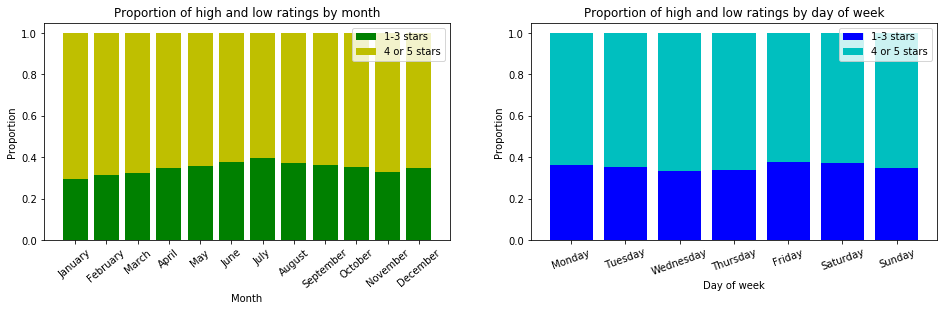

In [50]:
#Make bar plots of proportions of high and low ratings by month & by day of week
prop_lower_ratings_month = high_low_by_month.loc[:,'lower_ratings'] / num_ratings_by_month.values
prop_higher_ratings_month = high_low_by_month.loc[:,'higher_ratings'] / num_ratings_by_month.values
label_pos_month = np.arange(12)
labels_month = list(high_low_by_month.index)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
p1_month = plt.bar(label_pos_month, prop_lower_ratings_month, align='center', color='g')
p2_month = plt.bar(label_pos_month, prop_higher_ratings_month, align='center', color='y', bottom=prop_lower_ratings_month)
plt.xticks(label_pos_month, labels_month, rotation=40)
plt.xlabel('Month')
plt.ylabel('Proportion')
plt.title('Proportion of high and low ratings by month')
plt.legend((p1_month[0], p2_month[0]),('1-3 stars', '4 or 5 stars'))


prop_lower_ratings_weekday = high_low_by_weekday.loc[:,'lower_ratings'] / num_ratings_by_weekday.values
prop_higher_ratings_weekday = high_low_by_weekday.loc[:,'higher_ratings'] / num_ratings_by_weekday.values
label_pos_weekday = np.arange(7)
labels_weekday = list(high_low_by_weekday.index)
plt.subplot(1,2,2)
p1_weekday = plt.bar(label_pos_weekday, prop_lower_ratings_weekday, align='center', color='b')
p2_weekday = plt.bar(label_pos_weekday, prop_higher_ratings_weekday, align='center', color='c', bottom=prop_lower_ratings_weekday)
plt.xticks(label_pos_weekday, labels_weekday, rotation=20)
plt.xlabel('Day of week')
plt.ylabel('Proportion')
plt.title('Proportion of high and low ratings by day of week')
plt.legend((p1_weekday[0], p2_weekday[0]),('1-3 stars', '4 or 5 stars'))

plt.show()

In [51]:
#Split data into reviews with at least 50% capital letters and those with less than 50% capital letters
more_capitals = english_reviews[english_reviews['reviewPercentCaps'] >= 0.5]
fewer_capitals = english_reviews[english_reviews['reviewPercentCaps'] < 0.5]

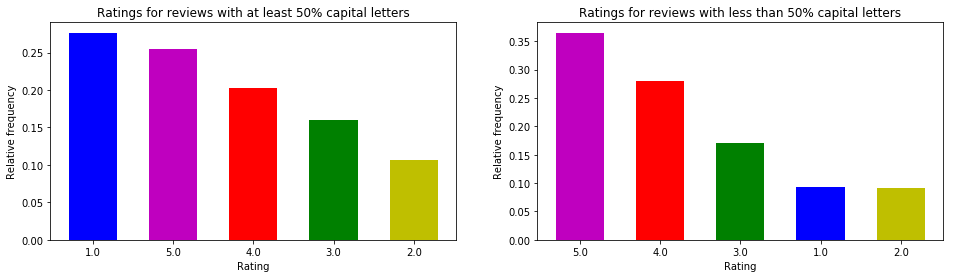

In [52]:
#Plot separate bar graphs (relative frequencies) of ratings for reviews with at least 50% capital letters and reviews with less than 50% capitals
rel_freq_more_caps = (more_capitals['reviews.rating'].value_counts().values) / len(more_capitals)
pos_more_caps = np.arange(5)
rating_labels_more_caps = list(more_capitals['reviews.rating'].value_counts().index)
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.bar(pos_more_caps, rel_freq_more_caps, align='center', color=['b','m','r','g','y'], width=0.6)
plt.xticks(pos_more_caps, rating_labels_more_caps)
plt.xlabel('Rating')
plt.ylabel('Relative frequency')
plt.title('Ratings for reviews with at least 50% capital letters')

rel_freq_less_caps = (fewer_capitals['reviews.rating'].value_counts().values) / len(fewer_capitals)
pos_less_caps = np.arange(5)
rating_labels_less_caps = list(fewer_capitals['reviews.rating'].value_counts().index)
plt.subplot(1,2,2)
plt.bar(pos_less_caps, rel_freq_less_caps, align='center', color=['m','r','g','b','y'], width=0.6)
plt.xticks(pos_less_caps, rating_labels_less_caps)
plt.xlabel('Rating')
plt.ylabel('Relative frequency')
plt.title('Ratings for reviews with less than 50% capital letters')
plt.show()

In [68]:
#Check if there are any null values in the postal code column
len(english_reviews[english_reviews['postalCode'].isna()])

0

In [107]:
#Create DataFrame of average rating by postal code for choropleth map
zip_code_avg = pd.DataFrame(english_reviews.groupby('postalCode')['reviews.rating'].mean()).reset_index()

In [109]:
#Identify zip codes corresponding to Hawaii and Alaska
zip_codes_hawaii_bool = zip_code_avg['postalCode'].apply(str).str.match('967|968')
zip_codes_alaska_bool = zip_code_avg['postalCode'].apply(str).str.match('[995-999]')

In [111]:
zip_codes_mainland_us = zip_code_avg[(~(zip_codes_hawaii_bool)) & (~(zip_codes_alaska_bool))]

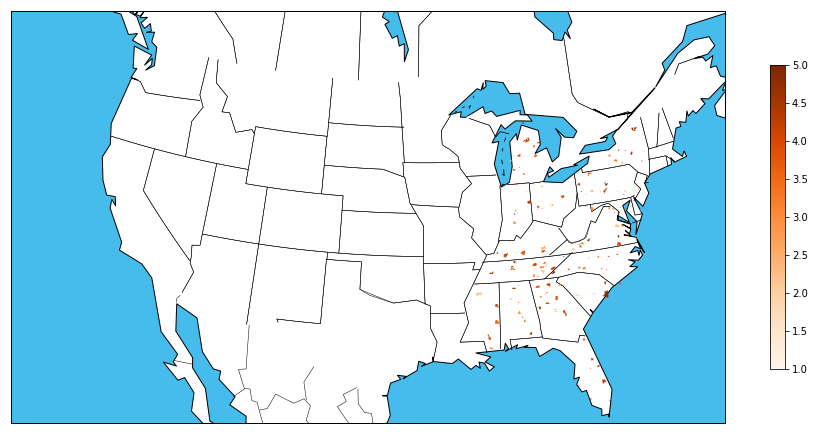

In [137]:
#Make choropleth map of average rating by zip code
f, ax = plt.subplots(figsize=(16,14))
m = Basemap(resolution='c', projection='lcc', lat_0=36.22, lon_0=-94.52, llcrnrlon=-124.88, llcrnrlat=21, urcrnrlon=-62.16, urcrnrlat=50.44, ax=ax)
m.drawmapboundary(fill_color='#46bcec')
m.fillcontinents(color='white', lake_color='#46bcec')
m.drawcoastlines()
m.drawstates()
m.readshapefile('./cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k', 'all_zip_codes', drawbounds=False)

#df_zip_polygons = pd.DataFrame({'shapes': [Polygon(np.array(shape), True) for shape in m.all_zip_codes], 'code': [area['ZCTA5CE10'] for area in m.all_zip_codes_info]})

#zip_codes_merged = pd.merge(zip_codes_mainland_us, df_zip_polygons, left_on='postalCode', right_on='code', how='left', sort=False)

#zip_codes_merged.dropna(axis=0, inplace=True)

cmap = plt.get_cmap('Oranges')   
pc = PatchCollection(zip_codes_merged.shapes, zorder=2)
norm = Normalize()
 
pc.set_facecolor(cmap(norm(zip_codes_merged['reviews.rating'].values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
mapper.set_array(zip_codes_merged['reviews.rating'])
plt.colorbar(mapper, shrink=0.4)
plt.show()

### Exploratory Data Analysis: Statistical Inference

In [53]:
ratings_weekday_crosstab

weekday_num,0,1,2,3,4,5,6
reviews.rating,,,,,,,
1.0,441,387,323,333,519,460,344
2.0,453,383,317,369,450,447,316
3.0,724,674,609,644,951,819,623
4.0,1238,1090,1074,1156,1412,1292,1029
5.0,1615,1556,1412,1496,1757,1622,1376


In [54]:
#Perform chi-square test of homogeneity to check whether distribution of frequency counts by star rating is identical across weekdays
stats.chi2_contingency(observed=ratings_weekday_crosstab)[0:2]

(56.971474523208755, 0.00016876525045208212)

In [55]:
high_low_by_weekday.transpose()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
lower_ratings,1618,1444,1249,1346,1920,1726,1283
higher_ratings,2853,2646,2486,2652,3169,2914,2405


In [56]:
#Perform chi-square test of homogeneity to check whether distribution of frequency counts of well-rated vs. lower-rated hotels is identical across weekdays
stats.chi2_contingency(observed=high_low_by_weekday.transpose())[0:2]

(31.207197955275507, 2.3141422482951734e-05)

In [57]:
ratings_month_crosstab

month_num,1,2,3,4,5,6,7,8,9,10,11,12
reviews.rating,,,,,,,,,,,,
1.0,99,132,203,213,235,346,460,359,272,227,125,136
2.0,104,117,146,218,239,317,452,344,266,291,117,124
3.0,231,254,326,373,483,563,786,604,469,440,257,258
4.0,438,447,573,641,788,943,1168,1001,738,762,391,401
5.0,606,659,835,865,935,1108,1400,1212,1021,989,632,572


In [58]:
#Perform chi-square test of homogeneity to check whether distribution of frequency counts by star rating is identical across months
stats.chi2_contingency(observed=ratings_month_crosstab)[0:2]

(175.55098376472205, 1.2556650040039886e-17)

In [59]:
high_low_by_month.transpose()

,January,February,March,April,May,June,July,August,September,October,November,December
lower_ratings,434,503,675,804,957,1226,1698,1307,1007,958,499,518
higher_ratings,1044,1106,1408,1506,1723,2051,2568,2213,1759,1751,1023,973


In [60]:
#Perform chi-square test of homogeneity to check whether distribution of frequency counts of well-rated vs. lower-rated hotels is identical across months
stats.chi2_contingency(observed=high_low_by_month.transpose())[0:2]

(95.90566486197744, 1.1507152986096332e-15)

In [61]:
#Perform t-test for difference of mean log(text length) between well-rated and lower-rated hotels
stats.ttest_ind(np.log(higher_ratings['len_textReview'].values), np.log(lower_ratings['len_textReview'].values), equal_var=False)

Ttest_indResult(statistic=-19.29700121503531, pvalue=2.944851885061953e-82)

In [62]:
#Function to perform one-vs-all hypothesis tests to compare difference of proportions of high ratings between each day and all others
def one_v_all_test(df):
    column_totals = df.apply(sum, axis=0)
    column_totals.rename('column_totals', inplace=True)
    new_df = df.append(column_totals)
    p_values_list = []
    num_success_others = 0
    num_obs_others = 0
    for i in new_df.columns:
        num_success_day = new_df.loc['higher_ratings', i]
        num_obs_day = new_df.loc['column_totals', i]
        for j in new_df.columns:
            if j != i:
                num_success_others += new_df.loc['higher_ratings', j]
                num_obs_others += new_df.loc['column_totals', j]
        #Compute p-value and apply Bonferroni correction
        p_values_list.append((i, proportions_ztest([num_success_day, num_success_others], [num_obs_day, num_obs_others], alternative='two-sided')[1]*len(new_df.columns)))
    return p_values_list

In [63]:
#Do one-vs-all test across months
print('The Bonferroni-corrected p-values for each month are:')
one_v_all_test(high_low_by_month.transpose())

The Bonferroni-corrected p-values for each month are:


[('January', 2.963131282307002e-06),
 ('February', 0.001460849740871659),
 ('March', 0.012030040824229834),
 ('April', 3.579452113675768),
 ('May', 10.983866699055094),
 ('June', 0.5827378086440379),
 ('July', 2.3195111658593545e-07),
 ('August', 0.7407109526629867),
 ('September', 4.568525691213944),
 ('October', 9.488320917437177),
 ('November', 0.2522183572494539),
 ('December', 5.699259285007435)]

In [64]:
#Do one-vs-all tests across weekdays
print('The Bonferroni-corrected p-values for each day of the week are:')
one_v_all_test(high_low_by_weekday.transpose())

The Bonferroni-corrected p-values for each day of the week are:


[('Monday', 2.7805269735778904),
 ('Tuesday', 4.8907245551604195),
 ('Wednesday', 0.03134213827427937),
 ('Thursday', 0.044437002111379124),
 ('Friday', 0.01797850570220444),
 ('Saturday', 0.18221879391363513),
 ('Sunday', 2.036127591868157)]

In [65]:
#Hypothesis test for difference in proportions of high ratings between reviews with more capital letters and reviews with fewer capital letters
more_caps_high_ratings = more_capitals['reviews.rating'].value_counts().loc[[4.0, 5.0]].sum()
fewer_caps_high_ratings = fewer_capitals['reviews.rating'].value_counts().loc[[4.0, 5.0]].sum()
proportions_ztest([more_caps_high_ratings, fewer_caps_high_ratings], [len(more_capitals), len(fewer_capitals)], alternative='two-sided')

(-3.7766666576024956, 0.00015894122245293385)